In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow import keras
import h5py #added

In [2]:
IMAGE_SIZE = 1024
BATCH_SIZE = 4
NUM_CLASSES = 13
DATA_DIR = r"\\fatherserverdw\Kevin\kevin_train\\"
train_images = sorted(glob(os.path.join(*[DATA_DIR, 'training',"im/*"])))
train_masks = sorted(glob(os.path.join(*[DATA_DIR, 'training',"label/*"])))
val_images = sorted(glob(os.path.join(*[DATA_DIR, 'validation',"im/*"])))
val_masks = sorted(glob(os.path.join(*[DATA_DIR, 'validation',"label/*"])))

In [3]:
# get 20 random images from training and 5 random images from validation:
train_images = train_images[:-1]
train_masks = train_masks[:-1]
val_images  = val_images[:-1]
val_masks = val_masks[:-1]

train_images = np.random.choice(train_images, size = 200, replace = False)
train_masks = np.random.choice(train_masks, size = 200, replace = False)
val_images = np.random.choice(val_images, size = 50, replace = False)
val_masks = np.random.choice(val_masks, size = 50, replace = False)
train_images = list(train_images)
train_masks = list(train_masks)
val_images = list(val_images)
val_masks = list(val_masks)

In [5]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    # image = cv2.imread(image_path.decode('UTF-8'))
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image[image==13]=0
        image = tf.where(tf.equal(image, 13), tf.zeros_like(image), image)
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = image / 127.5 - 1 #[-1 1]
        image = image/255 #[0 1]
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.map(lambda x,y: tf.numpy_function(load_data, [x,y], Tout=tf.uint8))
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [6]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>


In [7]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = tf.keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = tf.keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = tf.keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)
    input_a = tf.keras.layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    x = tf.keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = tf.keras.layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = tf.keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 1030, 1030,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, 512, 512, 64  9472        ['conv1_pad[0][0]']              
                                )                                                             

In [8]:
## Training

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=["accuracy"],
)

checkpoint_path = "fold_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1,
                                                 )
earlystop = keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1,
    )

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if epoch%2:
        return lr
    else:
        return lr * 0.1

lrschedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
round(model.optimizer.lr.numpy(), 5)


1e-04

In [9]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>

In [10]:
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(4, 1024, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 1024, 1024, 1), dtype=tf.float32, name=None))>

In [11]:
start = time()
history = model.fit(train_dataset, validation_data=val_dataset, epochs=40)
print(np.around(time()-start),'seconds elapsed')

Epoch 1/40
50/50 [==============================] - 960s 19s/step - loss: 1.2616 - accuracy: 0.7483 - val_loss: 2.6549 - val_accuracy: 0.0671
Epoch 2/40
50/50 [==============================] - 963s 19s/step - loss: 0.9015 - accuracy: 0.8142 - val_loss: 1.5275 - val_accuracy: 0.8085
Epoch 3/40
50/50 [==============================] - 960s 19s/step - loss: 0.8693 - accuracy: 0.8144 - val_loss: 1.1429 - val_accuracy: 0.8085
Epoch 4/40
50/50 [==============================] - 966s 19s/step - loss: 0.8462 - accuracy: 0.8143 - val_loss: 0.9755 - val_accuracy: 0.8085
Epoch 5/40
50/50 [==============================] - 951s 19s/step - loss: 0.8209 - accuracy: 0.8148 - val_loss: 0.9369 - val_accuracy: 0.8085
Epoch 6/40
50/50 [==============================] - 951s 19s/step - loss: 0.8020 - accuracy: 0.8162 - val_loss: 0.9720 - val_accuracy: 0.8085
Epoch 7/40
50/50 [==============================] - 951s 19s/step - loss: 0.7922 - accuracy: 0.8183 - val_loss: 0.9780 - val_accuracy: 0.8084
Epoch 

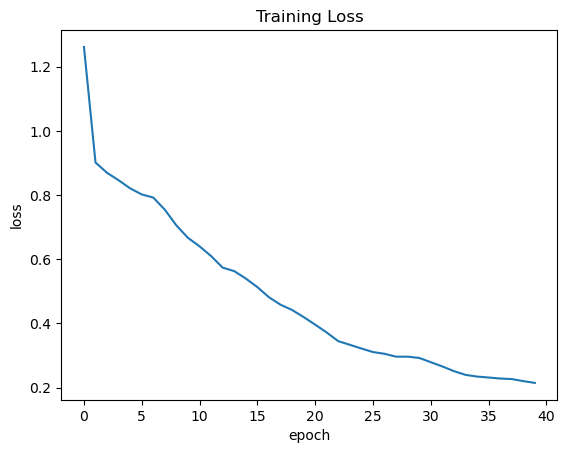

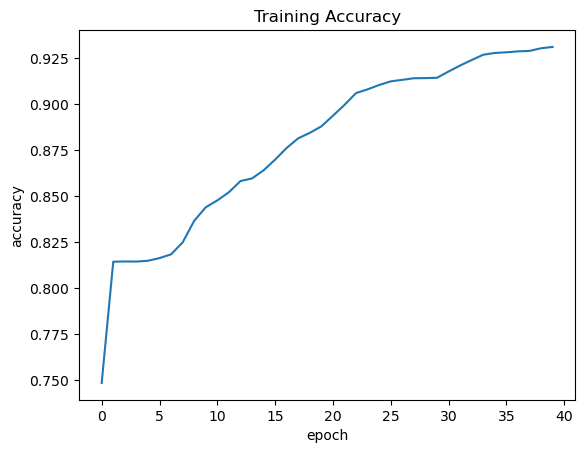

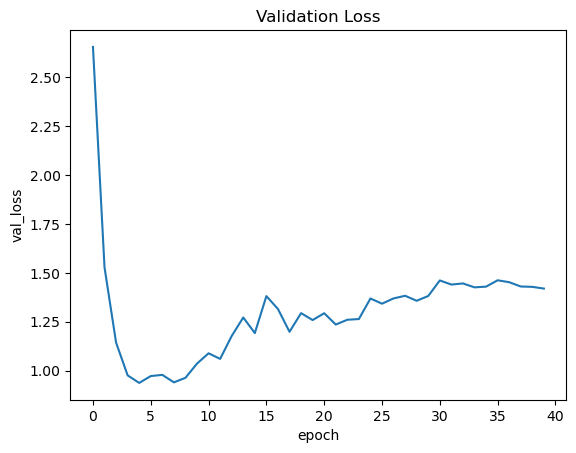

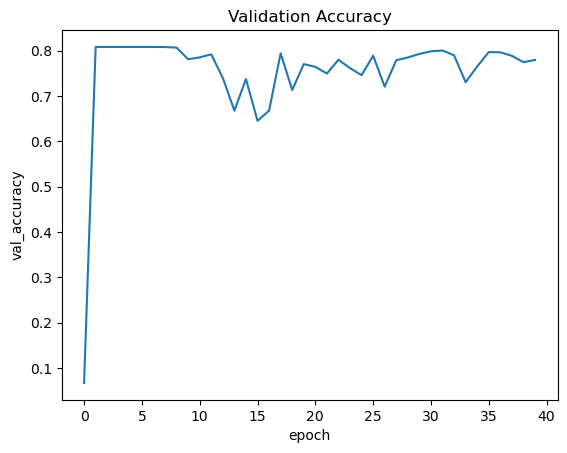

In [12]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()